## Import Relevant Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pmdarima as pm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

sns.set()

In [20]:
df = pd.read_csv("Walmart Data Analysis and Forcasting.csv")

## Exploratory Section

In [21]:
print(df.head())

print("\nColumns:", df.columns.tolist())

print("\nInfo:")
print(df.info())

print("\nDescription:")
print(df.describe())

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  

Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1 

## Preprocessing Section

In [22]:
df['Date'] = pd.to_datetime(df['Date'] , dayfirst= True)
df = df.sort_values('Date')
store1 = df[df['Store']==1]
store1 = store1.set_index('Date')

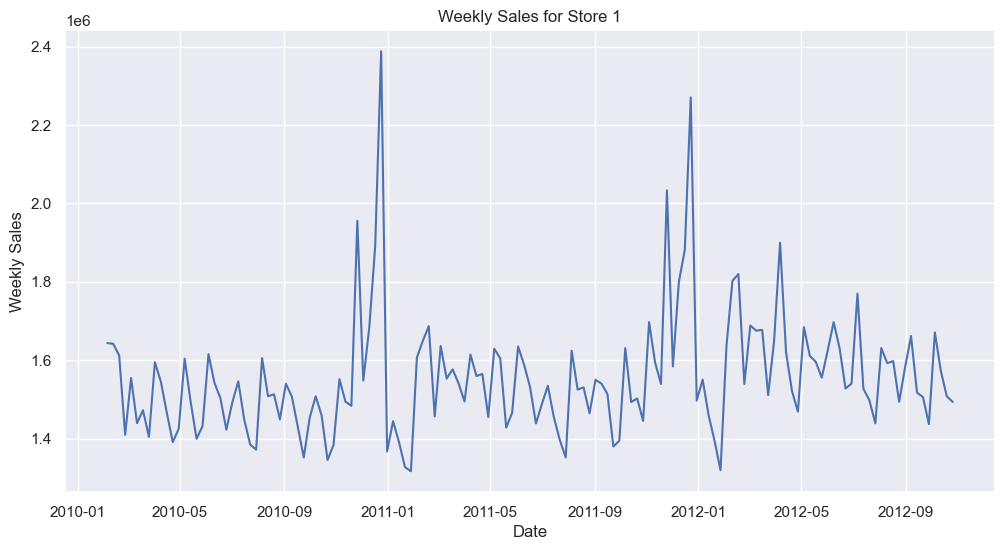

In [23]:
plt.figure(figsize=(12,6))
plt.plot(store1['Weekly_Sales'])
plt.title('Weekly Sales for Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


## Check for Stationarity

In [24]:
result = adfuller(store1['Weekly_Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.102186145192287
p-value: 1.3877788330759535e-05


## Check for Seasonality

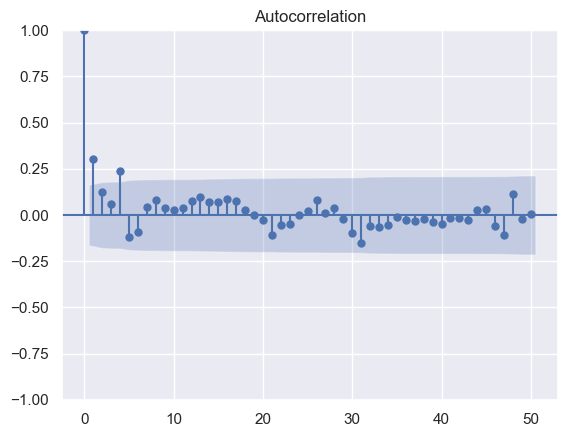

In [25]:
plot_acf(store1['Weekly_Sales'], lags=50)
plt.show()

<Figure size 2500x1000 with 0 Axes>

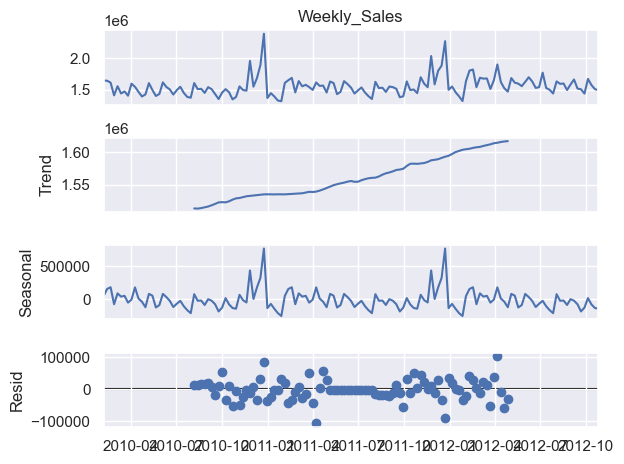

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_additive = seasonal_decompose(store1['Weekly_Sales'] , model='additive')
plt.figure(figsize=(25,10))
s_dec_additive.plot()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.02 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=377.854, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=375.869, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=5.47 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=277.509, Time=4.70 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=279.509, Time=10.42 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=279.509, Time=8.55 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=inf, Time=21.83 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=6.55 sec
 ARIMA(0,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=10.37 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=263.115, Time=4.64 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=3.91 sec

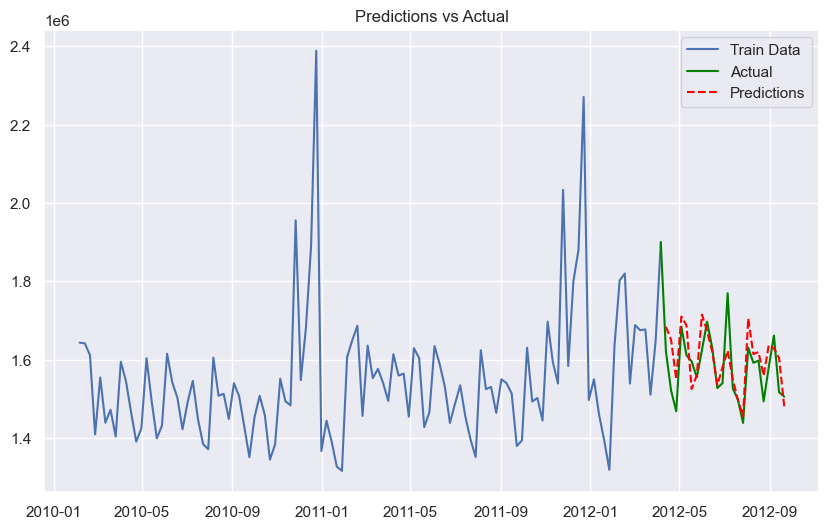

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Copy the 'Weekly_Sales' column from the DataFrame
y = store1[['Weekly_Sales']].copy()

# Save the original index before applying StandardScaler
y_index = y.index

# Apply StandardScaler to normalize the data
y_scaled = scaler.fit_transform(y)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(y_scaled) * 0.8)
train, test = y_scaled[:train_size], y_scaled[train_size:]

# Convert training and testing data to pandas Series with the original index
train_series = pd.Series(train.flatten(), index=y_index[:train_size])
test_series = pd.Series(test.flatten(), index=y_index[train_size:])

# Build the Auto ARIMA model on the training data
auto_model = pm.auto_arima(train_series, 
                           seasonal=True,   # Since the data is seasonal
                           m=52,            # The seasonal period is 52 weeks (annual cycle)
                           trace=True,      # To show the process of finding the best parameters
                           suppress_warnings=True,  # To suppress unnecessary warnings
                           stepwise=True)  # Use the stepwise algorithm for parameter search

# Print the summary of the model
print(auto_model.summary())

# Predict the next 4 weeks using the trained model
forecast_steps = 24
forecast = auto_model.predict(n_periods=forecast_steps)

# Convert forecast to numpy array and then inverse the scaling of the predictions to bring them back to the original scale
forecast_array = forecast.to_numpy().reshape(-1,1) # Convert to numpy array
forecast_original_scale = scaler.inverse_transform(forecast_array)


# Plot the predictions against the actual values
plt.figure(figsize=(10,6))
plt.plot(y[:train_size], label='Train Data')


# Plot the actual values corresponding to the forecast period
plt.plot(y[train_size-1 : train_size + forecast_steps].index, y[train_size-1 : train_size + forecast_steps]['Weekly_Sales'], label='Actual', color='green')
plt.plot(y[train_size:train_size+forecast_steps].index, forecast_original_scale, label='Predictions', color='red', linestyle='--')
plt.legend()
plt.title('Predictions vs Actual')
plt.show()


In [28]:
actual = y[train_size:train_size+forecast_steps]['Weekly_Sales'].values.reshape(-1, 1) # Actual Values

mae = mean_absolute_error(actual, forecast_original_scale) # Calculate mean absolute rror
rmse = np.sqrt(mean_squared_error(actual, forecast_original_scale)) # Calculate mean squared error
mape = np.mean(np.abs((actual - forecast_original_scale) / actual)) * 100 # mean absolute percentage error (MAPE)


print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



Mean Absolute Error (MAE): 49842.77
Root Mean Squared Error (RMSE): 62893.81
Mean Absolute Percentage Error (MAPE): 3.14%
